# 1次元の混合正規分布に対してのEMアルゴリズムを実装・描画
- https://cartman0.hatenablog.com/entry/2019/07/01/EM%E3%82%A2%E3%83%AB%E3%82%B4%E3%83%AA%E3%82%BA%E3%83%A0%E3%81%A7%E6%B7%B7%E5%90%88%E6%AD%A3%E8%A6%8F%E5%88%86%E5%B8%83%28MoG%29%E3%81%AE%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E3%82%92%E5%B0%8E
-  https://qiita.com/ta-ka/items/3e8b127620ac92a32864

In [1]:
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


In [2]:
# E-step
def EStep(k_size, data_x, lambda_vec, mu_vec, sigma2_vec):
    '''
    data_x[i]
    lambda[k]
    mu[k]
    sigma[k]
    '''
    I = len(data_x)
    # 中身を初期化せずに配列を作成する関数である。
    # 2行, 1000列の配列を生成
    responsibility = sp.empty((k_size, I))
    
    for k in sp.arange(k_size):
        norm = stats.norm(loc=mu_vec[k], scale=sp.sqrt(sigma2_vec[k]))
        responsibility[k] = norm.pdf(data_x)

    responsibility = responsibility / sp.sum(responsibility, axis=0)
    return responsibility

def MStep(k_size, responsibility, data_x):

    lambda_vec = sp.empty(k_size)
    mu_vec = sp.empty(k_size)
    sigma2_vec = sp.empty(k_size)

    for k in sp.arange(k_size):
        r_k = responsibility[k]
        #lambda_vec[k] = sp.sum(r_k) / sp.sum(responsibility)
        lambda_vec[k] = sp.sum(r_k) / responsibility.shape[1]
        mu_vec[k] = sp.sum(r_k * data_x) / sp.sum(r_k)
        mu_vec[k] = sp.sum(r_k * data_x) / sp.sum(r_k)
        sigma2_vec[k] = sp.sum(r_k * (data_x - mu_vec[k])**2) / sp.sum(r_k)

    return lambda_vec, mu_vec, sigma2_vec

In [3]:
def calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec):
    pdf = sp.zeros_like(x)

    for k in sp.arange(k_size):
        norm_k = stats.norm(loc=mu_vec[k], scale=sp.sqrt(sigma2_vec[k]))
        
        # pdf (Probability density function) 確率密度関数
        # xのときの値を取得
        pdf += lambda_vec[k] * norm_k.pdf(x)
    return pdf

# データの生成  
- f1：平均2, 分散1, データ数667    
- f2：平均-2, 分散1, データ数333  
- f1とf2の割合は2/3:1/3

In [34]:
# 乱数seedの固定
np.random.seed(seed=123)

# 平均40, 分散100
N1 = stats.norm(loc=40, scale=sp.sqrt(10*10))
# 平均70, 分散25
N2 = stats.norm(loc=70, scale=sp.sqrt(5*5))

# rvs (Random variates) 確率変数
s1 = N1.rvs(size=6000)
s2 = N2.rvs(size=4000)

# データの連結
data_x = sp.hstack((s1, s2))
data_x

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  import sys
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.hstack is deprecated and will be removed in SciPy 2.0.0, use numpy.hstack instead
  


array([29.14369397, 49.97345447, 42.82978498, ..., 67.63866793,
       72.90982183, 74.85306431])

(array([6.79084354e-05, 6.79084354e-05, 2.03725306e-04, 5.09313265e-04,
        6.79084354e-04, 2.07120728e-03, 4.07450612e-03, 6.99456884e-03,
        1.02202195e-02, 1.42607714e-02, 1.82673691e-02, 2.06102101e-02,
        2.42093572e-02, 2.42093572e-02, 2.13232487e-02, 1.93878583e-02,
        1.33779618e-02, 9.50718095e-03, 7.60574476e-03, 7.16433993e-03,
        1.33100533e-02, 2.10176607e-02, 2.95741236e-02, 3.03211164e-02,
        2.24437379e-02, 1.19179304e-02, 4.34613986e-03, 1.46003136e-03,
        2.37679524e-04, 1.01862653e-04]),
 array([ 1.98621803,  4.93136025,  7.87650247, 10.82164469, 13.7667869 ,
        16.71192912, 19.65707134, 22.60221356, 25.54735578, 28.49249799,
        31.43764021, 34.38278243, 37.32792465, 40.27306687, 43.21820908,
        46.1633513 , 49.10849352, 52.05363574, 54.99877796, 57.94392018,
        60.88906239, 63.83420461, 66.77934683, 69.72448905, 72.66963127,
        75.61477348, 78.5599157 , 81.50505792, 84.45020014, 87.39534236,
        90.34048

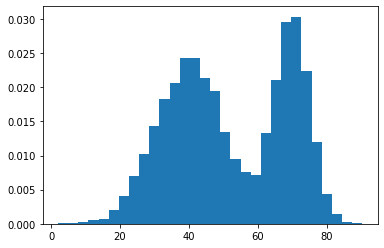

In [35]:
plt.hist(data_x, bins=30, density=True)

## 初期値の設定  
- データをランダムに2分割  
- それぞれの平均値を初期値に用いる
- 分散は全体の標本分散を用いる  
  
## 参考
- 入門　パターン認識と機械学習(https://www.coronasha.co.jp/np/isbn/9784339024791/)


In [36]:
# データをランダムに2分割
random_x = np.split(data_x, 2)
random_x1 = random_x[0]
random_x2 = random_x[1]

In [37]:
mu1_first = np.mean(random_x1)
sigma1_first = np.sum((random_x1 - np.mean(data_x))**2)/random_x1.shape[0]
print("mu1の初期値", mu1_first)
print("sigma1の初期値", sigma1_first)

mu2_first = np.mean(random_x2)
sigma2_first = np.sum((random_x2 - np.mean(data_x))**2)/random_x2.shape[0]
print("mu2の初期値", mu2_first)
print("sigma2の初期値", sigma2_first)

mu1の初期値 40.21082886827433
sigma1の初期値 238.7315098916443
mu2の初期値 63.97324033898476
sigma2の初期値 326.7968568251647


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  del sys.path[0]
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


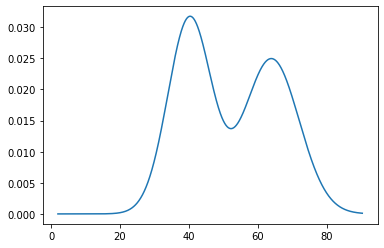

In [38]:
# 混合正規分布の数
k_size = 2

# 正規分布の割合
lambda_vec=[0.5, 0.5]

# 平均(mu)の初期値
mu_vec=[mu1_first, mu2_first]
# 分散(sigma)の初期値
sigma2_vec=[mu1_first, mu2_first]

# データ(-6から6までを200こ)
x = sp.linspace(np.min(random_x), np.max(random_x), 10000)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec), label="ini")


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  from ipykernel import kernelapp as app
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.sum is deprecated and

i: 0 lambda [0.50962933 0.49037067] mu [37.65195341 67.09923086] sigma2 [67.95339743 64.0903065 ]
i: 5 lambda [0.56880181 0.43119819] mu [39.15419457 69.15858808] sigma2 [82.75806482 34.5245127 ]
i: 10 lambda [0.58060064 0.41939936] mu [39.50652139 69.5149436 ] sigma2 [87.42752779 30.3468599 ]
i: 15 lambda [0.58198294 0.41801706] mu [39.55004021 69.55358674] sigma2 [88.05882471 29.93361292]
i: 20 lambda [0.58212651 0.41787349] mu [39.55459037 69.5575568 ] sigma2 [88.12557764 29.89167277]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  from ipykernel import kernelapp as app
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.empty is deprecated and will 

i: 25 lambda [0.58214122 0.41785878] mu [39.55505666 69.55796289] sigma2 [88.13242651 29.88738835]
i: 30 lambda [0.58214272 0.41785728] mu [39.55510434 69.55800441] sigma2 [88.13312699 29.88695035]
i: 35 lambda [0.58214287 0.41785713] mu [39.55510922 69.55800866] sigma2 [88.13319861 29.88690557]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is dep

i: 40 lambda [0.58214289 0.41785711] mu [39.55510972 69.55800909] sigma2 [88.13320593 29.88690099]
i: 45 lambda [0.58214289 0.41785711] mu [39.55510977 69.55800914] sigma2 [88.13320668 29.88690053]
i: 50 lambda [0.58214289 0.41785711] mu [39.55510977 69.55800914] sigma2 [88.13320675 29.88690048]


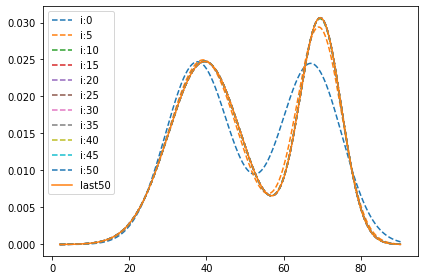

In [39]:
# 50回繰り返す
for i in sp.arange(50+1):
    # Estep
    # responsibilityの更新 
    responsibility = EStep(k_size, data_x, lambda_vec, mu_vec, sigma2_vec)
    
    # Mstep
    # 混合割合, 平均, 分散の更新
    lambda_vec, mu_vec, sigma2_vec = MStep(k_size, responsibility, data_x)
    
    if i % 5 == 0:
        print("i:", i, "lambda", lambda_vec, "mu", mu_vec, "sigma2", sigma2_vec)
        plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec), label=f"i:{i}", linestyle="--")
        
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec), label=f"last{i}", linestyle="-")

plt.legend()
plt.tight_layout()
plt.show()

In [40]:
k_size

2

In [41]:
print("f1の混合比率", lambda_vec[0])
print("mu1", mu_vec[0])
print("sigma1", sigma2_vec[0])

f1の混合比率 0.582142889716446
mu1 39.555109774617655
sigma1 88.13320675340094


In [42]:
print("f2の混合比率", lambda_vec[1])
print("mu2", mu_vec[1])
print("sigma2", sigma2_vec[1])

f2の混合比率 0.417857110283554
mu2 69.5580091401554
sigma2 29.88690047817448


# 真の値
- 平均40, 分散100  
N1 = stats.norm(loc=40, scale=sp.sqrt(10*10))  
- 平均70, 分散25  
N2 = stats.norm(loc=70, scale=sp.sqrt(5*5))  

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


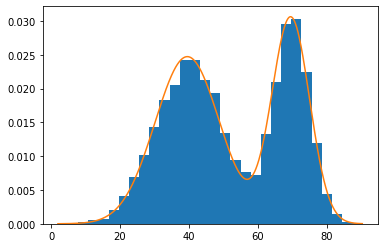

In [43]:
# 推定された分布の可視化
plt.hist(data_x, bins=30, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec), label=f"last{i}", linestyle="-")

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  after removing the cwd from sys.path.


(array([6.79084354e-05, 6.79084354e-05, 2.03725306e-04, 5.09313265e-04,
        6.79084354e-04, 2.07120728e-03, 4.07450612e-03, 6.99456884e-03,
        1.02202195e-02, 1.42607714e-02, 1.82673691e-02, 2.06102101e-02,
        2.42093572e-02, 2.42093572e-02, 2.13232487e-02, 1.93878583e-02,
        1.33779618e-02, 9.50718095e-03, 7.60574476e-03, 7.16433993e-03,
        1.33100533e-02, 2.10176607e-02, 2.95741236e-02, 3.03211164e-02,
        2.24437379e-02, 1.19179304e-02, 4.34613986e-03, 1.46003136e-03,
        2.37679524e-04, 1.01862653e-04]),
 array([ 1.98621803,  4.93136025,  7.87650247, 10.82164469, 13.7667869 ,
        16.71192912, 19.65707134, 22.60221356, 25.54735578, 28.49249799,
        31.43764021, 34.38278243, 37.32792465, 40.27306687, 43.21820908,
        46.1633513 , 49.10849352, 52.05363574, 54.99877796, 57.94392018,
        60.88906239, 63.83420461, 66.77934683, 69.72448905, 72.66963127,
        75.61477348, 78.5599157 , 81.50505792, 84.45020014, 87.39534236,
        90.34048

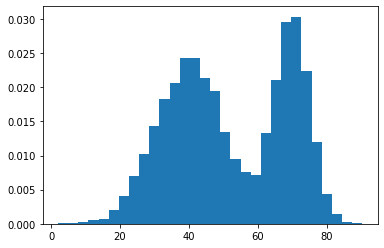

In [44]:
# 平均40, 分散100
new_N1 = stats.norm(loc=mu_vec[0], scale=sp.sqrt(sigma2_vec[0]))
# 平均70, 分散25
new_N2 = stats.norm(loc=mu_vec[1], scale=sp.sqrt(sigma2_vec[1]))

# rvs (Random variates) 確率変数
new_s1 = new_N1.rvs(size=int(lambda_vec[0]*10000))
new_s2 = new_N2.rvs(size=int(lambda_vec[1]*10000))


plt.hist(data_x, bins=30, density=True)

(array([0.00082352, 0.00658815, 0.02288204, 0.05594042, 0.06864613,
        0.05605806, 0.02764668, 0.00617639, 0.00082352, 0.00017647]),
 array([51.08902124, 55.15800902, 59.22699679, 63.29598456, 67.36497233,
        71.4339601 , 75.50294787, 79.57193564, 83.64092342, 87.70991119,
        91.77889896]),
 <a list of 10 Patch objects>)

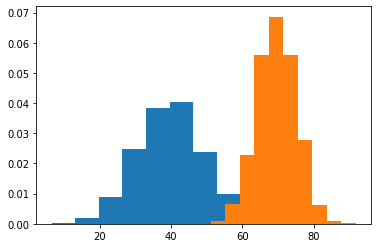

In [45]:
plt.hist(new_s1, density=True)
plt.hist(new_s2, density=True)

In [46]:
int(lambda_vec[1]*10000)

4178